<a href="https://colab.research.google.com/github/devbabbar7/DeepLearning.AI-TensorFlow/blob/main/Convolutional%20Neural%20Networks%20in%20TensorFlow/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning
In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called transfer learning and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

just get the convolution layers of one model
attach some dense layers onto it
train just the dense network
evaluate the results
Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

IMPORTANT NOTE: This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

###Setup the pretrained model
You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the InceptionV3 architecture as your base model. To do that, you need to:

Set the input shape to fit your application. In this case. set it to 150x150x3 as you've been doing in the last few labs.

Pick and freeze the convolution layers to take advantage of the features it has learned already.

Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the InceptionV3 model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [24]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-04-29 17:14:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   135MB/s    in 0.6s    

2023-04-29 17:14:33 (135 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [25]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [26]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_8[0][0]']               
 alization)                                                                                       
                                                                                       

In [27]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [28]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_8[0][0]']               
 alization)                                                                                       
                                                                                              

In [29]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#Prepare the dataset
Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.



In [30]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-04-29 17:17:03--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   218MB/s    in 0.3s    

2023-04-29 17:17:03 (218 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [31]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)


Epoch 1/20
100/100 - 27s - loss: 0.3299 - accuracy: 0.8700 - val_loss: 0.0996 - val_accuracy: 0.9690 - 27s/epoch - 274ms/step
Epoch 2/20
100/100 - 19s - loss: 0.2207 - accuracy: 0.9055 - val_loss: 0.0956 - val_accuracy: 0.9640 - 19s/epoch - 189ms/step
Epoch 3/20
100/100 - 20s - loss: 0.1919 - accuracy: 0.9245 - val_loss: 0.1303 - val_accuracy: 0.9480 - 20s/epoch - 199ms/step
Epoch 4/20
100/100 - 19s - loss: 0.1903 - accuracy: 0.9230 - val_loss: 0.1179 - val_accuracy: 0.9550 - 19s/epoch - 190ms/step
Epoch 5/20
100/100 - 19s - loss: 0.1688 - accuracy: 0.9335 - val_loss: 0.1606 - val_accuracy: 0.9400 - 19s/epoch - 193ms/step
Epoch 6/20
100/100 - 21s - loss: 0.1596 - accuracy: 0.9390 - val_loss: 0.0988 - val_accuracy: 0.9610 - 21s/epoch - 207ms/step
Epoch 7/20
100/100 - 20s - loss: 0.1479 - accuracy: 0.9410 - val_loss: 0.1330 - val_accuracy: 0.9510 - 20s/epoch - 202ms/step
Epoch 8/20
100/100 - 22s - loss: 0.1484 - accuracy: 0.9435 - val_loss: 0.0903 - val_accuracy: 0.9700 - 22s/epoch - 222

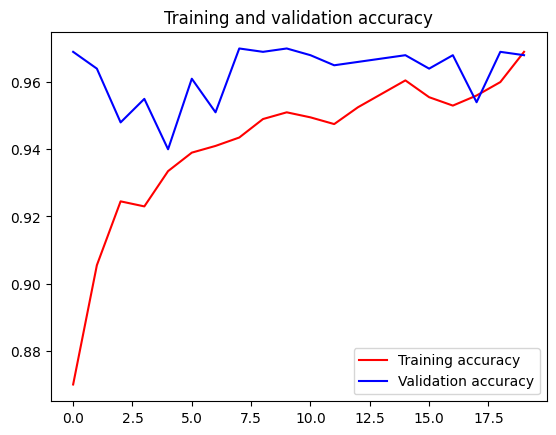

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()